In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

<a name="0"></a>
# Decision Tree Classifier

The purpose of this notebook is to attempt to build a decision tree classifier for the Covid-19 patient data set. In addition, we will compare the decision tree classifier to our logistic regression model from the previous notebook. 

1. [Load the Data](#1)
2. [Pre-Processing](#2)
3. [The Logistic Regression model](#3)
4. [Decision Tree Classifer](#4)
5. [Validation Curve for Max depth](#5)
5. [Cross Validation and Comparison of the Models](#6)
7. [Learning Curve for Decision Tree Classifier](#7)

In [3]:
import models
import sqlite3
import pandas as pd
from tabulate import tabulate
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import patsy

sns.set(style="whitegrid")
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.latex.repr', True)
pd.set_option('display.latex.longtable', True)

In [4]:
np.random.seed(324389210)
random.seed(432389210)

<a name="1"></a>
### Load the Data

[Back to Contents](#0)

First, we will load the data used in the linear models notebook from our database:

In [5]:
con = sqlite3.connect('data.db')

In [6]:
query = """
SELECT * 
FROM Covid_19_patient_data
"""

df = pd.read_sql_query(query, con)

In [7]:
df.head()

,index,length_of_stay,age,death,severity,black,white,asian,latino,myocardial_infarction,...,aspartate_aminotransferase,alanine_aminotransferase,white_blood_cell,lymphocytes,interleukin6,C_reactive_protein,procalcitonin,troponin,temp_F,race
0,0,1,89,0,3,0,0,0,0,0,...,26.0000,14.0000,5.6000,1.4000,0.0000,0.4999,0.0000,0.0100,98.4000,black
1,1,2,67,1,7,0,1,0,0,0,...,85.0000,32.0000,12.2000,0.3000,0.0000,14.9000,0.6000,1.2000,97.4000,white
2,2,2,94,1,7,0,1,0,0,0,...,32.0000,18.0000,6.1000,0.5000,324.1000,33.9000,1.2000,0.0000,102.6000,white
3,3,15,72,0,9,1,0,0,0,1,...,44.0000,17.0000,3.7000,0.5000,0.0000,18.4000,7.3000,0.0500,102.0000,black
4,4,9,71,0,7,1,0,0,0,0,...,38.0000,28.0000,5.7000,1.4000,39.4000,11.6000,0.0000,0.0100,100.5000,black


<a name="2"></a>
### Pre-Processing

[Back to Contents](#0)

Now that we have our data, we can drop any columns we won't be needing and drop any duplicates, although we can assume we probably have very unique data for each patient. 

In [8]:
# drop non-encoded columns or columns we didn't use for linear model at all
df = df.drop(['race', 'severity','index'], axis=1)

# Drop Duplicates
df = df.drop_duplicates()

# Reset Index since we removed duplicates
df = df.reset_index(drop=True)

# Verify steps are done correctly
df.head()

,length_of_stay,age,death,black,white,asian,latino,myocardial_infarction,peripheral_vascular_disease,congestive_heart_disease,...,sodium,aspartate_aminotransferase,alanine_aminotransferase,white_blood_cell,lymphocytes,interleukin6,C_reactive_protein,procalcitonin,troponin,temp_F
0,1,89,0,0,0,0,0,0,0,0,...,135.0000,26.0000,14.0000,5.6000,1.4000,0.0000,0.4999,0.0000,0.0100,98.4000
1,2,67,1,0,1,0,0,0,1,0,...,137.0000,85.0000,32.0000,12.2000,0.3000,0.0000,14.9000,0.6000,1.2000,97.4000
2,2,94,1,0,1,0,0,0,1,1,...,140.0000,32.0000,18.0000,6.1000,0.5000,324.1000,33.9000,1.2000,0.0000,102.6000
3,15,72,0,1,0,0,0,1,0,0,...,132.0000,44.0000,17.0000,3.7000,0.5000,0.0000,18.4000,7.3000,0.0500,102.0000
4,9,71,0,1,0,0,0,0,0,0,...,149.0000,38.0000,28.0000,5.7000,1.4000,39.4000,11.6000,0.0000,0.0100,100.5000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 38 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   length_of_stay                         4175 non-null   int64  
 1   age                                    4175 non-null   int64  
 2   death                                  4175 non-null   int64  
 3   black                                  4175 non-null   int64  
 4   white                                  4175 non-null   int64  
 5   asian                                  4175 non-null   int64  
 6   latino                                 4175 non-null   int64  
 7   myocardial_infarction                  4175 non-null   int64  
 8   peripheral_vascular_disease            4175 non-null   int64  
 9   congestive_heart_disease               4175 non-null   int64  
 10  cardiovascular_disease                 4175 non-null   int64  
 11  deme

Our data is now ready for modeling and further analysis. 

<a name="3"></a>
### The Logistic Regression model

[Back to Contents](#0)

Based on the results from the 'building the linear model' notebook, we can recreate the same logistic regression model for comparison with the Decision Tree Classifier.

In [10]:
df['AST_ALT'] = df['aspartate_aminotransferase'] / df ['alanine_aminotransferase']
df['creatinine_log'] = df['creatinine'].apply(lambda x: np.log(x))
df['troponin_sq'] = df['troponin']**2

In [11]:
formula = "death ~ age + congestive_heart_disease + chronic_obstructive_pulmonary_disease + all_central_nervous_system_disease + renal_disease \
                + stroke + oxygen_saturation + mean_arterial_pressure + D_dimer + platelets + creatinine \
                + sodium + AST_ALT + C_reactive_protein + procalcitonin + troponin + length_of_stay + creatinine_log:renal_disease"

final = models.bootstrap_logistic_regression(formula, df)
models.describe_bootstrap_lgr(final, sd=5)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.00227,-0.00329,0.00930,0.50057
age,$\beta_{1}$,0.04685,0.04143,0.05411,0.01171
congestive_heart_disease,$\beta_{2}$,0.00647,-0.03538,0.04566,0.00162
chronic_obstructive_pulmonary_disease,$\beta_{3}$,0.00870,-0.02020,0.03275,0.00218
all_central_nervous_system_disease,$\beta_{4}$,0.04784,0.00318,0.09693,0.01196
renal_disease,$\beta_{5}$,0.05642,0.00782,0.13125,0.01411
stroke,$\beta_{6}$,0.02022,0.00415,0.04203,0.00505
oxygen_saturation,$\beta_{7}$,-0.03950,-0.05021,-0.03069,-0.00987
mean_arterial_pressure,$\beta_{8}$,-0.04295,-0.04984,-0.03770,-0.01074


The most important metric we will be referring to when comparing the model's is the *error rate*, which is 17.37% for our logistic regression model. This can also be expressed as the *accuracy*, which is about 82.63% for our logistic regression model. Keep in mind that, for comparison purposes, we are forgoing any log and square transformations we had in the final model from the previous notebook. 

<a name="4"></a>
### The Decision Tree Classifier

[Back to Contents](#0)

Finally, we can begin building the decision tree classifier using the same features in the logistic regression model, in order to compare their accuracy. In addition, we can use graphviz to visualize the decision tree classifier. 

In [12]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics 
from sklearn.tree import export_graphviz
from IPython.display import Image  
! pip install pydotplus
import pydotplus
! pip install graphviz
import graphviz

We can define a function for calculating the error rate, which we can compare to sklearn's accuracy score to ensure that the metrics are the same.

In [13]:
def error_rate(y, y_hat):
    return np.sum(np.abs(y - y_hat))/len(y)*100

Using the same variables, minus the log and square root transformations, we can build our decision tree classifier as follows:

In [14]:
seed = 101

features = ['length_of_stay', 'age', 'AST_ALT', 'congestive_heart_disease', 'chronic_obstructive_pulmonary_disease', 
            'renal_disease', 'all_central_nervous_system_disease', 'stroke', 'oxygen_saturation',  'mean_arterial_pressure', 
            'D_dimer', 'platelets', 'creatinine', 'sodium', 'C_reactive_protein', 'procalcitonin', 'troponin']
       

X = df[features]
y = df.death

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [15]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", random_state=101, max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_true = np.array(y_test)
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy (sklearn):",metrics.accuracy_score(y_test, y_pred))
print("Error rate (sklearn):",1-metrics.accuracy_score(y_test, y_pred))
print(f"Accuracy: {100 - error_rate(y_true, y_pred)}")
print(f"Error rate: {error_rate(y_true, y_pred)}")

Accuracy (sklearn): 0.8220271348762969
Error rate (sklearn): 0.17797286512370314
Accuracy: 82.2027134876297
Error rate: 17.79728651237031


The decision tree classifier has an error rate of 17.80%, which is greater than the error rate for the logistic regression model which was 16.93%. We can visualize the decision tree as follows:

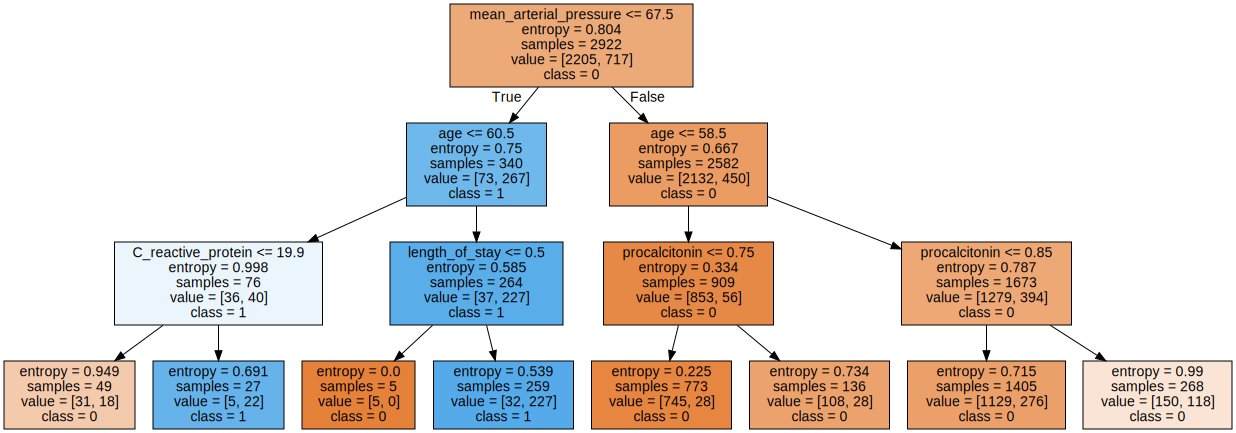

In [16]:
# DOT data
dot_data = export_graphviz(clf, out_file=None, 
                                feature_names=features,  
                                class_names=['0', '1'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render('Covid-19 Survival Decision Tree',format='png', view=False)

graph

Now that we have a completed decision tree, we can determine if the depth we used, which was a max depth of 3, is optimal.

<a name="5"></a>
### Validation Curve for Decision Tree depth

[Back to Contents](#0)

In order to determine the optimal tree depth, with the best bias/variance tradeoff, we can plot a validation curve for increasing tree depths as follows:

In [17]:
def validation_curve(seed, X, y, min_depth, max_depth, test_size=0.30):
    train_scores = []
    test_scores = []
    
    for i in range(min_depth, max_depth + 1):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=101)
        
        clf = DecisionTreeClassifier(criterion="entropy", random_state=101, max_depth=i)

        clf = clf.fit(X_train,y_train)
        
        y_pred = clf.predict(X_train)
        train_scores.append(error_rate(y_train, y_pred))
        
        y_pred = clf.predict(X_test)
        test_scores.append(error_rate(y_test, y_pred))
        
    return train_scores, test_scores

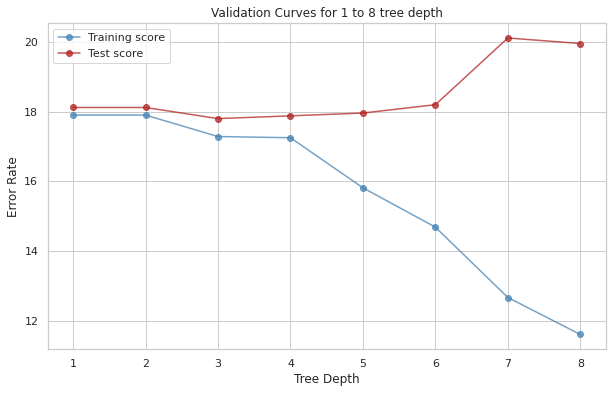

In [18]:
seed = 101
min_depth = 1
max_depth = 8
param_range = range(min_depth, max_depth + 1)
x_label = 'Tree Depth'
y_label = 'Error Rate'
title = "Validation Curves for {0} to {1} tree depth".format(min_depth, max_depth)

train_scores, test_scores = validation_curve(seed, X, y, min_depth, max_depth)

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(param_range, train_scores, 'o-', color="steelblue", alpha=0.75, label="Training score")
axes.plot(param_range, test_scores, "o-", color="firebrick", alpha=0.75, label="Test score")
axes.set_xlabel(x_label)
axes.set_ylabel(y_label)
axes.set_title(title)
plt.legend(loc="best")
plt.show()
plt.close()

Based on the validation curve, the optimal depth that is best for the bias variance trade off is three, since greater depths tend to overfit the model. 

<a name="6"></a>
### Cross Validation and Comparison of the models

[Back to Contents](#0)

In order to compare the models, we can perform cross validation and generate bootstrap samples from the cross validation results, which we will use to find the difference in error between the models. For our purposes, we will perform three rounds of 10-Fold cross validation.

In [19]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [20]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            y = np.ravel( y) # need for logistic regression
            results = models.summarize(formula, X, y, model, style='logistic')
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [21]:
lgr_result = cross_validation(models.logistic_regression, formula, df, lambda r: (r["sigma"], r["r_squared"]))

The above result is the cross validation results for our logistic regression model. Now, we can perform cross validation for the Decision tree classifier using sklearn's built in functions as follows:

In [22]:
# Set Seed first
seed = 101

# Perform 10 fold CV
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)

#Train the model using the training sets 
classifier = DecisionTreeClassifier(criterion="entropy", random_state=seed, max_depth=4)
classifier.fit(X_train,y_train)
results = model_selection.cross_val_score(classifier, X, y, cv=kfold)
print(results.mean())

0.8174847681663282


The cross validation mean is decent, at 0.82. Now, we can move on to Bayesian inference in order to compare the models.

In [23]:
dt_results = []
for i in range(0, 3):
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=101)

    #Train the model using the training sets 
    classifier = DecisionTreeClassifier(criterion="entropy", random_state=seed, max_depth=4)
    classifier.fit(X_train,y_train)
    results = model_selection.cross_val_score(classifier, X, y, cv=kfold)
    dt_results = np.concatenate((dt_results, results), axis=None)

In [24]:
np.mean(dt_results)

0.8174847681663281

We can generate bootstrap samples to estimate the difference of the means between the decision tree classifier and the logistic regression model.

In [25]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [26]:
lgr_bootstrap = bootstrap_sample([(100 - r[0])/100 for r in lgr_result], np.mean)
dt_bootstrap = bootstrap_sample(dt_results, np.mean)
difference = dt_bootstrap - lgr_bootstrap

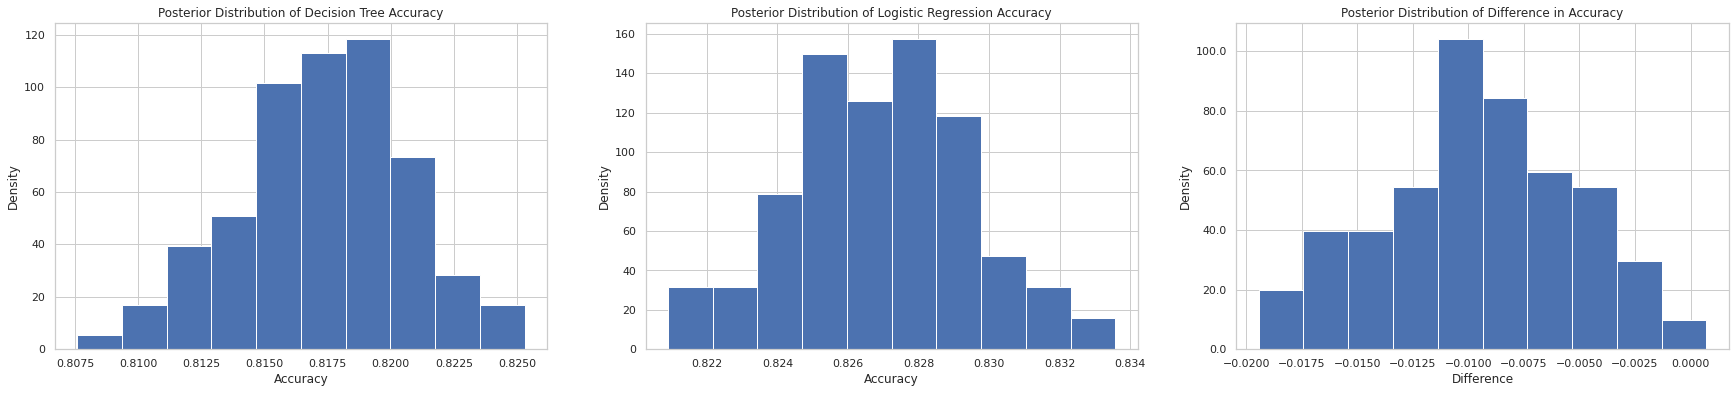

In [27]:
from matplotlib.ticker import StrMethodFormatter

figure = plt.figure(figsize=(30, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(dt_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Accuracy")
axes.set_title( "Posterior Distribution of Decision Tree Accuracy")

axes = figure.add_subplot(1, 3, 2)

axes.hist(lgr_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Accuracy")
axes.set_title( "Posterior Distribution of Logistic Regression Accuracy")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in Accuracy")

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.show()
plt.close()

In [28]:
print("P(DT > LGR)", np.mean(difference >= 0))
print("P(LGR > DT)", np.mean(difference < 0))

P(DT > LGR) 0.01
P(LGR > DT) 0.99


Based on these results, there is a 1% chance that the decision tree classifier is a better model, based on the data and with the current features. Interesting! 

<a name="7"></a>
### Learning Curve for Decision Tree Classifier

[Back to Contents](#0)

Let's look at the learning curve to see how we may be able to improve the model. 

In [29]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    from sklearn.model_selection import learning_curve
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.25,
                     color="steelblue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.25, color="firebrick")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="firebrick",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid(visible=True)
    plt.show()
    plt.close()

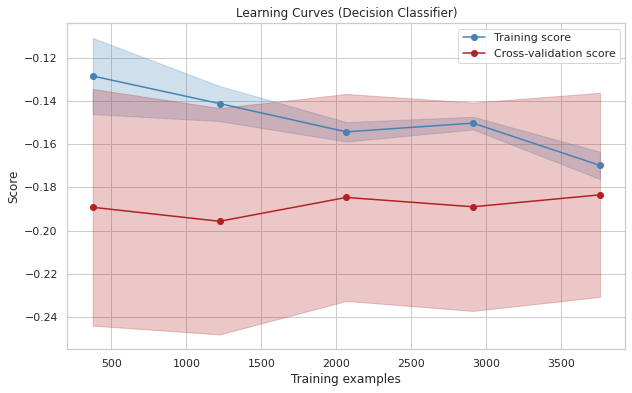

In [30]:
seed = 101
title = "Learning Curves (Decision Classifier)"
estimator = DecisionTreeClassifier(criterion = "entropy", random_state=seed, max_depth=4)
plot_learning_curve(estimator, title, X, y, cv=10, n_jobs=1)

It seems that our model would benefit from more data, since we still have a pretty significant gap between the curves, although it seems to start converging right at the very end. If we wanted to take the decision tree route, we may need to modify the features used in the model, re-evaluate the number of features, and consider more data. 